In [ ]:
# !pip install transformers
# !pip install -q torch torchvision torchaudio

In [ ]:
from google.colab import files,drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/gdrive/MyDrive/finn-project/be-ai-model')

from data_processing import get_csv_data, merge_data
from sentiment_model import analyze_sentiment_with_progress, add_integer_column, sums_sentiment_score_for_7_days
from lstm_model import get_train_scale_data, get_test_scale_data, create_sequences, compile_model, train_model, predict_prices
from final_result import compare_prices_with_graph


In [ ]:
import pandas as pd

news_train_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_news_train.csv")
news_test_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_news_test.csv")

news_train_df = analyze_sentiment_with_progress(news_train_df)
news_test_df = analyze_sentiment_with_progress(news_test_df)

감성 분석 진행중:   0%|          | 0/391 [00:00<?, ?batch/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


감성 분석 진행중:   0%|          | 0/224 [00:00<?, ?batch/s]

In [ ]:
stock_train_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_prices_train.csv")
stock_test_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_prices_test.csv")

stock_train_df['date'] = pd.to_datetime(stock_train_df['date']).dt.strftime('%Y-%m-%d')
stock_test_df['date'] = pd.to_datetime(stock_test_df['date']).dt.strftime('%Y-%m-%d')

In [ ]:
merged_train = merge_data(news_train_df, stock_train_df)
merged_test = merge_data(news_test_df, stock_test_df)

merged_train['sentiment_influence'] = 0.0
merged_test['sentiment_influence'] = 0.0

merged_train = add_integer_column(merged_train)
merged_test = add_integer_column(merged_test)

sums_sentiment_score_for_7_days(merged_train)
sums_sentiment_score_for_7_days(merged_test)

  0%|          | 0/12482 [00:00<?, ?it/s]

  0%|          | 0/7141 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features = ['sentiment_influence', 'open', 'high', 'low', 'adjClose', 'volume']
target   = 'close'

merged_train = merged_train[ features + [target] ].dropna()
merged_test  = merged_test[ features + [target] ].dropna()

train_scaled = get_train_scale_data(scaler, merged_train)
test_scaled = get_test_scale_data(scaler, merged_test)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [ ]:
from tensorflow.keras.models import load_model

def get_existing_model(path):
  load_path = '/content/drive/MyDrive/finn-project/models/finn_model.h5'
  return load_model(load_path)

In [ ]:
model = compile_model(X_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0089 - val_loss: 5.6675e-04
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.5939e-04 - val_loss: 3.8801e-04
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.1389e-04 - val_loss: 3.1600e-04
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.5742e-05 - val_loss: 1.5915e-04
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.1010e-05 - val_loss: 1.5546e-04
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.3365e-05 - val_loss: 1.1860e-04
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.8870e-05 - val_loss: 1.4734e-04
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.7969e-05 - val_loss: 1.3516e-04
Epoch 9/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.1987e-05 - val_loss: 8.0537e-05
Epoch 10/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.5866e-05 - val_loss: 1.6213e-04
Epoch 11/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.

In [ ]:
y_pred_scaled = predict_prices(model, X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
import numpy as np

all_cols = ['sentiment_influence', 'open', 'high', 'low', 'adjClose', 'volume', 'close']
features = all_cols[:-1] # 'close'를 제외한 모든 컬럼
target = 'close'
target_col_index = all_cols.index(target)

num_features = len(features)
dummy_array = np.zeros((len(y_pred_scaled), len(all_cols)))
# 'close' 위치(6번 인덱스)에 예측된 값을 삽입
dummy_array[:, target_col_index] = y_pred_scaled.ravel()
# Scaler를 이용해 전체 배열을 역변환하고, 'close' 컬럼만 추출
y_pred_actual = scaler.inverse_transform(dummy_array)[:, target_col_index]

# y_test도 역변환
dummy_array_test = np.zeros((len(y_test), len(all_cols)))
dummy_array_test[:, target_col_index] = y_test.ravel()
y_test_actual = scaler.inverse_transform(dummy_array_test)[:, target_col_index]

In [ ]:
# 이제 y_pred는 실제 주가 스케일의 예측값입니다.
next_day_predicted_close = y_pred_actual[-1]
print(f"예측된 실제 종가: ${next_day_predicted_close:.4f}")

예측된 실제 종가: $347.2190


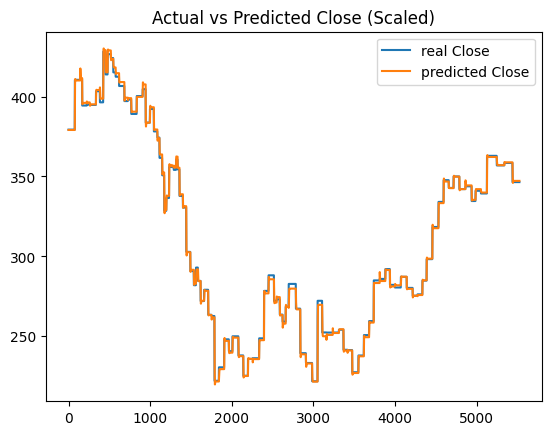

In [ ]:
compare_prices_with_graph(y_test_actual, y_pred_actual)

In [ ]:
save_path = '/gdrive/MyDrive/finn-project/models/finn_model.h5'
model.save(save_path)